### Natcha Jangphiphatnawakit 63340500031

# Homework: Word Embedding

In this exercise, you will work on the skip-gram neural network architecture for Word2Vec. You will be using Keras to train your model. 

You must complete the following tasks:
1. Read/clean text files
2. Indexing (Assign a number to each word)
3. Create skip-grams (inputs for your model)
4. Create the skip-gram neural network model
5. Visualization
6. Evaluation (Using pre-trained, not using pre-trained)
    (classify topic from 4 categories) 
    
This notebook assumes you have already installed Tensorflow and Keras with python3 and had GPU enabled. If you run this exercise on GCloud using the provided disk image you are all set.



In [3]:
# %tensorflow_version 2.x
%matplotlib inline
import numpy as np
import matplotlib as plt
import pandas as pd
import math
import glob
import re
import random
import collections
import os
import sys
import tensorflow as tf
import keras
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dropout
from keras.models import load_model
from keras.layers import Embedding, Reshape, Activation, Input, Dense, Masking, Conv1D, Bidirectional
from tensorflow.python.keras.layers.merge import Dot
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence
from keras import backend as K
from keras.optimizers import Adam

random.seed(42)

# Step 1: Read/clean text files

The given code can be used to processed the pre-tokenzied text file from the wikipedia corpus. In your homework, you must replace those text files with raw text files.  You must use your own tokenizer to process your text files

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# import shutil
# shutil.copy("/content/drive/MyDrive/FRA 501 IntroNLP&DL/Dataset/wiki.zip","/content/wiki.zip")
# shutil.copy("/content/drive/MyDrive/FRA 501 IntroNLP&DL/Dataset/BEST-TrainingSet.zip","/content/BEST-TrainingSet.zip")

In [6]:
# !unzip wiki.zip
# !unzip BEST-TrainingSet.zip

In [7]:
#Step 1: read the wikipedia text file
with open("./wiki/thwiki_chk.txt") as f:
    #the delimiter is one or more whitespace characters
    input_text = re.compile(r"\s+").split(f.read()) 
    #exclude an empty string from our input
    input_text = [word for word in input_text if word != ''] 

In [8]:
tokens = input_text
print(tokens[:10])
print("total word count:", len(tokens))

['หน้า', 'หลัก', 'วิกิพีเดีย', 'ดำเนินการ', 'โดย', 'มูลนิธิ', 'วิกิ', 'มีเดีย', 'องค์กร', 'ไม่']
total word count: 36349066


# Step 2: Indexing (Assign a number to each word)

The code below generates an indexed dataset(each word is represented by a number), a dictionary, a reversed dictionary

## <font color='purple'>Homework Question 1:</font>
<font color='purple'>“UNK” is often used to represent an unknown word (a word which does not exist in your dictionary/training set). You can also represent a rare word with this token as well.  How do you define a rare word in your program? Explain in your own words and capture the screenshot of your code segment that is a part of this process</font>

 + <font color='purple'>edit or replace create_index with your own code to set a threshold for rare words and replace them with "UNK"</font>

## <font color='red'>Answer</font>

1. Counting number of UNK word, if word count is less than or equal to min_thres_unk, then the word is considered UNK. Add token 'UNK' to the word_count list which value is count of UNK words. (need to remove 'UNK' in word_count dictionary first because there are words that contain the string 'UNK' in the input_text.).

![1](https://github.com/njrean/NLP_HW2/blob/main/picture/UNK1.png?raw=true)

2. Sorted list word_count by its value in descending order.

![3](https://github.com/njrean/NLP_HW2/blob/main/picture/UNK2.png?raw=true)

3. Create a dictionary that maps each word to its corresponding index in the word_count dictionary. The key of the dictionary should be the word, and the value should be the index of the word in the word_count list.

![2](https://github.com/njrean/NLP_HW2/blob/main/picture/UNK4.png?raw=true)

4. Use the dictionary to transform each word in dataset into sequencs of unique number. For each word, check its frequency count in the sorted dictionary. If the count is greater than min_thres_unk for UNK words, assign the word its own unique number based on its index in the sorted dictionary. If the word is 'UNK' or if its frequency count is less than or equal to the minimum threshold for UNK words, assign it the number 9 (which represents 'UNK' in this dataset).

![4](https://github.com/njrean/NLP_HW2/blob/main/picture/UNK3.png?raw=true)

In [9]:
#step 2:Build dictionary and build a dataset(replace each word with its index)
from collections import defaultdict

def create_index(input_text, min_thres_unk = 1, max_word_count = None):
    # TODO#1 : edit or replace this function
    words = [word for word in input_text ]
    word_count = list()

    #word_count => list of count number of word in each unique words  [(word, count), ...]
    #use set and len to get the number of unique words
    word_count.extend(collections.Counter(words).most_common(len(set(words))))
    #include a token for unknown word
    # word_count.append(("UNK",0))
    #print out 10 most frequent words
    print(word_count[-10:])

    #thresold to token UNK
    count_unk = 0
    idx_unk = 0
    #loop for counting UNK Word wich frequency equal or less than thresold
    for i, pair in enumerate(word_count):
        if pair[1] <= min_thres_unk:
            count_unk += pair[1]
        if pair[0] == "UNK": #count "UNK" in original input text
            count_unk += pair[1]
            idx_unk = i

    pop_data = word_count.pop(idx_unk) #pop word 'UNK' which in sentence in input text
    word_count.append(("UNK", count_unk))

    print('UNK count:', count_unk)
    print('pop data:', pop_data)
    print('add new data:', word_count[-1])
    
    #sort dict word count by using value
    word_count = [pair for pair in word_count if pair[1] > min_thres_unk]
    word_count = sorted(word_count, key=lambda x: x[1], reverse=True)

    #Rank theshold frequency
    if max_word_count != None:
        word_count = word_count[:max_word_count]

    #dictionary => is dict consist of word and unique number for each word {("for_keras_zero_padding", 0), (word1, 1), ...}
    dictionary = dict()
    dictionary["for_keras_zero_padding"] = 0
    for word in word_count:
        dictionary[word[0]] = len(dictionary)

    #reverse_dictionary is just reverse dictionary : swap values and keys
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    #create data set sequences by dictionary
    data = list()
    for word in input_text:
        if word in dictionary.keys():
            data.append(dictionary[word])
        else: data.append(dictionary['UNK'])

    return data, dictionary, reverse_dictionary

# call method with min_thres_unk=1ß
dataset, dictionary, reverse_dictionary = create_index(tokens, 1)
print('Number of sequence in dataset:', len(dataset))
print('Number of word in dictionary:', len(dictionary))

[('ไคเซอร์วิลเฮ็ล์ม', 1), ('Jugen', 1), ('เมืองลอเรนซ์เคิร์ช', 1), ('รัป', 1), ('ค็อปเฟอร์มันน์', 1), ('กับค็อปเฟอร์มันน์', 1), ('เมลท์', 1), ('ลิเซลอตต์', 1), ('(ก.พ.', 1), ('ทักกีสำเร็จการ', 1)]
UNK count: 406196
pop data: ('UNK', 4)
add new data: ('UNK', 406196)
Number of sequence in dataset: 36349066
Number of word in dictionary: 295164


In [10]:
print("output sample (dataset):",dataset[:10])
print("output sample (dictionary):",{k: dictionary[k] for k in list(dictionary)[:13]})
print("output sample (reverse dictionary):",{k: reverse_dictionary[k] for k in list(reverse_dictionary)[:13]})

output sample (dataset): [230, 209, 2454, 574, 16, 1830, 7150, 3125, 682, 25]
output sample (dictionary): {'for_keras_zero_padding': 0, 'ที่': 1, 'ใน': 2, 'เป็น': 3, 'และ': 4, 'การ': 5, 'มี': 6, 'ของ': 7, 'ได้': 8, 'UNK': 9, ')': 10, '"': 11, 'จาก': 12}
output sample (reverse dictionary): {0: 'for_keras_zero_padding', 1: 'ที่', 2: 'ใน', 3: 'เป็น', 4: 'และ', 5: 'การ', 6: 'มี', 7: 'ของ', 8: 'ได้', 9: 'UNK', 10: ')', 11: '"', 12: 'จาก'}


# Step3: Create skip-grams (inputs for your model)
Keras has a skipgrams-generator, the cell below shows us how it generates skipgrams 

## <font color='purple'>Homework Question 2:</font>
<font color='purple'>The negative samples are sampled from sampling_table.  Look through Keras source code to find out how they sample negative samples. Discuss the sampling technique taught in class and compare it to the Keras source code.</font>



<font color='yellow'>Q2: PUT YOUR ANWSER HERE!!!</font>
## <font color='red'>Answer</font>

From vanilla skip-gram model has serveral disavantages such as high computational costs due to the soft max activation function. So, one of alternative ways to solve is a skip-gram negative sampling approach.

Negative sample is the pair (terget word, context word) which context word is not in skip_window neighbor of target word.

The original idea of skip-gram model is to predict probability of each word being the context word for a given input word (target word), as illustrated in Figure 1. And you will see that the compution of each proablity for each word for comparing the true lable is computationally expensive see in equation below. Therefore, The idea of negative sampling is converting multi-classification task into binary-classification task. This involves predicting, for a given input pair of target word and context word, whether the given context word is within the window of the target word or not. The output of this approach is the weight matrix W_input, which consists of the vector of each word. By using negative sampling, the computational costs of the skip-gram model can be reduced.

<center><img src="https://github.com/njrean/NLP_HW2/blob/main/picture/skipgram1.png?raw=true" width="500"></center>

<center><img src="https://github.com/njrean/NLP_HW2/blob/main/picture/skipgram2.png?raw=true" width="300"></center>

According to negative skip-gram idea as mention before, you will see we want a pair of target word and context word to be a input and want label positive (1) or negative (0) samples to be an output.

For keras source code in this section, is the way to provide dataset to train negative sampling skip-graam model, generate pair of target word and context word. In code, start by generate sampling table to use in skipgrams function it will return proability of sampling for each word. Probability of common word will less than rare word because we need to balance distribution of random words. The skipgrams function generate random pair of target word and context word which are contain both positive samples and negative samples. The function returns the variable "couples", which is a set of pairs of samples consisting of an equal number of positive and negative samples, as well as the variable "labels", which is a list of binary labels (1 for positive and 0 for negative) for each pair of samples.

In [11]:
# Step 3: Create data samples
vocab_size = len(dictionary)
skip_window = 1       # How many words to consider left and right.

# TODO#2 check out keras source code and find out how their sampling technique works. Describe it in your own words.
sample_set= dataset[:10]
sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(sample_set, vocab_size, window_size=skip_window, sampling_table=sampling_table, seed=27)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples, labels)
print("number of couples:", len(couples))

for i in range(8):
    print(reverse_dictionary[couples[i][0]],reverse_dictionary[couples[i][1]])

[[25, 682], [2454, 219950], [25, 3408], [3125, 682], [2454, 115575], [2454, 209], [209, 230], [209, 2454], [2454, 574], [209, 83708], [3125, 7150], [3125, 145853], [3125, 285707], [209, 235515]] [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
number of couples: 14
ไม่ องค์กร
วิกิพีเดีย โปลู
ไม่ ปน
มีเดีย องค์กร
วิกิพีเดีย บวรราชสกุล
วิกิพีเดีย หลัก
หลัก หน้า
หลัก วิกิพีเดีย


# Step 4: create the skip-gram model
## <font color='purple'>Homework Question 3:</font>
 <font color='purple'>Q3:  In your own words, discuss why Sigmoid is chosen as the activation function in the  skip-gram model.</font>

<font color='yellow'>Q3: PUT YOUR ANSER HERE!!!</font>
## <font color='red'>Answer</font>

According to the idea of the negative skipgram we mention in Question 2, the original skip-gram model computes the probability of every word in the corpus being a context word of a given target word in one iteration, which is computationally expensive, then we adapt the model to predict pairs of words by returning only true or false. So, the reasons why sigmoid is chosen in this skip-gram model are the negative skip-gram model predict binary classification problem and the prediction is to find that context word in pair is context in window neighbor of the target or not.

In [12]:
#reference: https://github.com/nzw0301/keras-examples/blob/master/Skip-gram-with-NS.ipynb
dim_embedddings = 32
V= len(dictionary)

#step1: select the embedding of the target word from W
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V, dim_embedddings)(w_inputs)

#step2: select the embedding of the context word from C
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V, dim_embedddings)(c_inputs)

#step3: compute the dot product:c_k*v_j
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)

#step4: normailize dot products into probability
o = Activation('sigmoid')(o)
#TO DO#4 Question: Why sigmoid?

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
opt=Adam(lr=0.01)
SkipGram.compile(loss='binary_crossentropy', optimizer=opt)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 32)        9445248     ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 32)        9445248     ['input_1[0][0]']                
                                                                                              

C:\Users\natch\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# you don't have to spend too much time training for your homework, you are allowed to do it on a smaller corpus
# currently the dataset is 1/20 of the full text file.
# for _ in range(2): #change training epoch to only 2 epochs 
#     prev_i=0
#     #it is likely that your GPU won't be able to handle large input
#     #just do it 100000 words at a time
#     for i in range(len(dataset)//100000):
#         #generate skipgrams
#         data, labels = skipgrams(sequence=dataset[prev_i*100000:(i*100000)+100000], vocabulary_size=V, window_size=2, negative_samples=4.)
#         x = [np.array(x) for x in zip(*data)]
#         y = np.array(labels, dtype=np.int32)
#         if x:
#             loss = SkipGram.train_on_batch(x, y)
#         prev_i = i 
#         print(loss,i*100000)

    # SkipGram.save_weights('my_skipgram32_weights-hw.h5')

In [ ]:
# SkipGram.save_weights('my_skipgram32_weights-hw.h5')

In [14]:
SkipGram.load_weights('my_skipgram32_weights-hw.h5')

In [15]:
#Get weight of the embedding layer
final_embeddings=SkipGram.get_weights()[0]
print(final_embeddings)
print(final_embeddings.shape)

[[ 0.02531729 -0.02946281  0.04880235 ... -0.03962885 -0.03181513
   0.04749901]
 [-0.5923195   0.638501    0.57130605 ... -0.58736396 -0.5965148
  -0.6051869 ]
 [-0.5876494   0.64405775  0.55796456 ... -0.6177761  -0.5388807
  -0.6410565 ]
 ...
 [ 0.42154825 -0.42779878 -0.4231688  ...  0.44138074  0.4024873
   0.41527295]
 [ 0.44871774 -0.4001138  -0.45722586 ...  0.48174128  0.37218374
   0.4085032 ]
 [ 0.46248862 -0.41925323 -0.40710974 ...  0.42223597  0.37607077
   0.40466177]]
(295164, 32)


# Step 5: Intrinsic Evaluation: Word Vector Analogies
## <font color='blue'>Homework Question 4: </font>
<font color='blue'> Read section 2.1 and 2.3 in this [lecture note](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes02-wordvecs2.pdf). Come up with 10 semantic analogy examples and report results produced by your word embeddings. Discuss t-SNE in 2 dimensions. </font>


In [ ]:
# TODO#4:Come up with 10 semantic analogy examples and report results produced by your word embeddings anf do t-SNE in 2 dimensions.
#and tell us what you observe

In [69]:
import matplotlib
#Thai font setup
matplotlib.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
matplotlib.rc('font', family='TH Sarabun New', size=14)

In [17]:
def cosine_similarity(u, v):
    distance = 0.0
    dot = np.dot(u,v)
    norm_u = np.sqrt(np.sum(np.square(u)))
    norm_v = np.sqrt(np.sum(np.square(v)))
    cosine_similarity = dot / (norm_u * norm_v)

    return cosine_similarity

In [18]:
def complete_analogy(list_word, word_to_vec, word_dict):
    word_a, word_b, word_c = list_word[0], list_word[1], list_word[2]

    #create word_to_vec_map
    word_to_vec_map = dict()
    for i, word in enumerate(word_dict):
      word_to_vec_map[word] = word_to_vec[i]
    
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()

    e_a, e_b, e_c = word_to_vec_map[word_a], word_to_vec_map[word_b], word_to_vec_map[word_c]
    
    words = word_to_vec_map.keys()
    max_cosine_sim = -100              
    best_word = None                   

    for w in words:        
        if w in [word_a, word_b, word_c] :
            continue
        
        cosine_sim = cosine_similarity(e_b - e_a, word_to_vec_map[w] - e_c)
        
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
        
    return best_word

In [61]:
def run_analogy(list_analogy, word_to_vec, word_dict):
    analogy_list = []
    print('a\t:\tb\t::\tc\t:\td\t\texpect')
    for a in list_analogy:
        best_word = complete_analogy(a, word_to_vec, word_dict)
        print('{}\t:\t{}\t::\t{}\t:\t{}\t\t{}'.format(a[0], a[1], a[2], best_word, a[3]))
        add_more = [a[0], a[1], a[2], best_word, a[3]]
        for others in a[4:]:
            add_more.append(others)
        analogy_list.append(add_more)

    return analogy_list

In [21]:
complete_analogy(['ชอบ', 'เกลียด', 'มิตร'], final_embeddings, dictionary)

'พเนจร'

In [73]:
#analogy -> [a, b, c, d, expected, other1, other2, ...]
#others are used to analysis in tsne plot.

analogy_word = [['พ่อ', 'แม่', 'น้อง', 'พี่', 'น้า', 'อา', 'ลุง', 'ป้า'],
                ['หยิน', 'หยาง', 'หญิง', 'ชาย'],
                ['น้ำหนัก', 'กิโลกรัม', 'ระยะ', 'กิโลเมตร', 'เมตร', 'เซนติเมตร'],
                ['ปลา', 'ครีบ', 'นก', 'ปีก'],
                ['เรือ', 'น้ำ', 'รถ', 'ถนน'],
                ['มั่งคั่ง', 'ร่ำรวย', 'อดอยาก', 'ยากจน'],
                ['ประเทศไทย', 'กรุงเทพ', 'ประเทศญี่ปุ่น', 'โตเกียว', 'ประเทศอังกฤษ', 'ลอนดอน', 'ประเทศจีน', 'ปักกิ่ง'],
                ['ชอบ', 'เกลียด', 'มิตร', 'ศัตรู'],
                ['บุญ', 'สวรรค์', 'บาป', 'นรก', 'นางฟ้า', 'ยมทูต', 'ยมบาล'],
                ['น้ำตาล', 'หวาน', 'เกลือ', 'เค็ม']]

In [74]:
analogy_analysis = run_analogy(analogy_word, final_embeddings, dictionary)

a	:	b	::	c	:	d		expect
พ่อ	:	แม่	::	น้อง	:	สี		พี่
หยิน	:	หยาง	::	หญิง	:	)		ชาย
น้ำหนัก	:	กิโลกรัม	::	ระยะ	:	00		กิโลเมตร
ปลา	:	ครีบ	::	นก	:	รูปรี		ปีก
เรือ	:	น้ำ	::	รถ	:	หรือ		ถนน
มั่งคั่ง	:	ร่ำรวย	::	อดอยาก	:	และแล้ว		ยากจน
ประเทศไทย	:	กรุงเทพ	::	ประเทศญี่ปุ่น	:	ปวช.		โตเกียว
ชอบ	:	เกลียด	::	มิตร	:	พเนจร		ศัตรู
บุญ	:	สวรรค์	::	บาป	:	ดั่ง		นรก
น้ำตาล	:	หวาน	::	เกลือ	:	สับสน		เค็ม


In [78]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl

# analogy_analysis = [[a1, b1, c1, d1], [a2, b2, c2, d2], ...]

def embedding_tsne(analogy_analysis, embeddings, dictionary):
    #find index
    flat_analogy = [word for group in analogy_analysis for word in group]
    selected_idx = [dictionary[word] for word in flat_analogy]
    max_idx = max(selected_idx)
    if max_idx < len(dictionary)-100:
        max_idx = max_idx+100
    print('max index:', max_idx)

    #reduce dimension
    tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=1000)
    low_dim_embs = tsne.fit_transform(embeddings[:max_idx,:])
    print('data calculate pca:', low_dim_embs.shape[0])

    low_dim_embs = low_dim_embs[selected_idx] #select and rearrage by analogy list

    return flat_analogy, low_dim_embs

def plot_tsne(analogy, low_dim_embs):
    # col = 2
    # row = math.ceil(len(analogy)/2)
    
    # # plot
    # fig, ax = plt.subplots(nrows=row, ncols=col, figsize = (10,30))
    # for i, group in enumerate(analogy):
    #     for j, label in enumerate(group):
    #         idx = (i*4) + j
    #         x, y = low_dim_embs[idx, :]
    #         ax[i//2, i%2].scatter(x, y)
    #         ax[i//2, i%2].annotate(label,
    #                     xy=(x, y),
    #                     xytext=(5, 2),
    #                     textcoords='offset points',
    #                     ha='right',
    #                     va='bottom')
    #         ax[i//2, i%2].legend(['a', 'b', 'c', 'd', 'expect'])
            
    #plot every point in one graph
    flat_label = [label for group in analogy for label in group]
    plt.figure(figsize=(10, 15))
    plt.axis('off')
    for i, label in enumerate(flat_label):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
    plt.show()

In [76]:
flat_analogy, low_dim_embs = embedding_tsne(analogy_analysis, final_embeddings, dictionary)

max index: 59104
data calculate pca: 59104


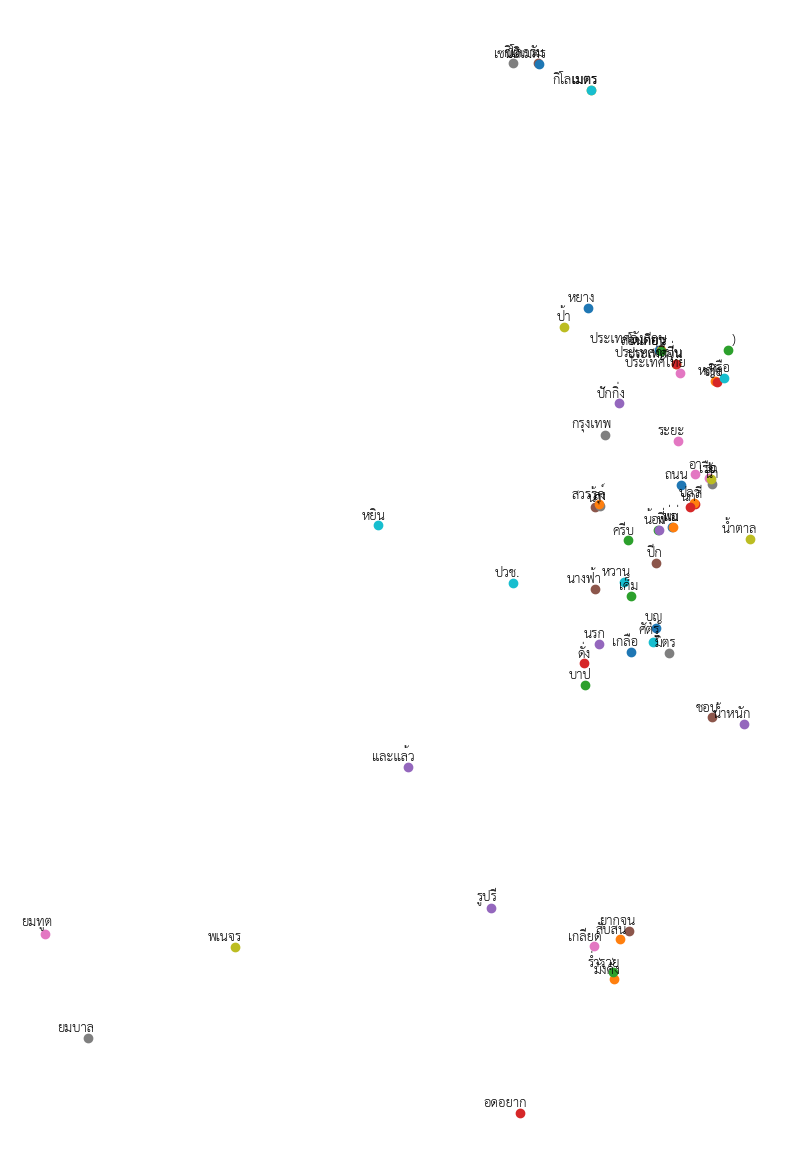

In [79]:
plot_tsne(analogy_analysis, low_dim_embs)

## <font color='red'>Answer Question4</font>
Analysis word analogy <br>

a : b :: c : ?(d) and expected word

From word analogy analysis, there are no predictions which similar to the expected word. There are three points that could affect the result. <br>
1. The information in the dataset which is used to train to skip-gram almost does not define or represent the word by its context.
2. The quantity of the dataset could be more than the used dataset.

From the plots by TSNE, the interesting point are the following:
1. When the plot combines every analogy word, the words in the same domain are also in the same area.
    - family member (พ่อ แม่ พี่ น้อง)
    - contry and capital city (ประเทศไทย ประเทศญี่ปุ่น ประเทศจีน ประเทศอังกฤษ)
    - measure (กิโลกรัม กิโลเมตร เซนติเมตร)
2. There are some pairs of antonyms or synonyms that are close to each other.
    - มั่งคั่ง ร่ำรวย
    - ศัตรู มิตร

In conclusion, trained word vectors can represent only some words, it could be affected by information in data that is not enough and suitable for creating word vectors.

# Step 6: Extrinsic Evaluation

## <font color='blue'>Homework Question5:</font>
<font color='blue'>
Use the word embeddings from the skip-gram model as pre-trained weights (GloVe and fastText) in a classification model. Compare the result the with the same classification model that does not use the pre-trained weights. 
</font>


In [28]:
all_news_filepath = glob.glob('BEST-TrainingSet/news/*.txt')
all_novel_filepath = glob.glob('BEST-TrainingSet/novel/*.txt')
all_article_filepath = glob.glob('BEST-TrainingSet/article/*.txt')
all_encyclopedia_filepath = glob.glob('BEST-TrainingSet/encyclopedia/*.txt')

In [29]:
#preparing data for the classificaiton model
#In your homework, we will only use the first 2000 words in each text file
#any text file that has less than 2000 words will be padded
#reason:just to make this homework feasible under limited time and resource
import keras
import tensorflow

max_length = 2000
def word_to_index(word):
    if word in dictionary:
        return dictionary[word]
    else:#if unknown
        return dictionary["UNK"]

def prep_data():
    input_text = list()
    for textfile_path in [all_news_filepath, all_novel_filepath, all_article_filepath, all_encyclopedia_filepath]:
        for input_file in textfile_path:
            f = open(input_file,"r") #open file with name of "*.txt"
            text = re.sub(r'\|', ' ', f.read()) # replace separation symbol with white space           
            text = re.sub(r'<\W?\w+>', '', text)# remove <NE> </NE> <AB> </AB> tags
            text = text.split() #split() method without an argument splits on whitespace 
            indexed_text = list(map(lambda x:word_to_index(x), text[:max_length])) #map raw word string to its index   
            if 'news' in input_file:
                input_text.append([indexed_text,0]) 
            elif 'novel' in input_file:
                input_text.append([indexed_text,1]) 
            elif 'article' in input_file:
                input_text.append([indexed_text,2]) 
            elif 'encyclopedia' in input_file:
                input_text.append([indexed_text,3]) 
            
            f.close()
    random.shuffle(input_text)
    return input_text

input_data = prep_data()
train_data = input_data[:int(len(input_data)*0.6)]
val_data = input_data[int(len(input_data)*0.6):int(len(input_data)*0.8)]
test_data = input_data[int(len(input_data)*0.8):]

train_input = [data[0] for data in train_data]
train_input = keras.utils.pad_sequences(train_input, maxlen=max_length) #padding
train_target = [data[1] for data in train_data]
train_target=to_categorical(train_target, num_classes=4)

val_input = [data[0] for data in val_data]
val_input = keras.utils.pad_sequences(val_input, maxlen=max_length) #padding
val_target = [data[1] for data in val_data]
val_target=to_categorical(val_target, num_classes=4)

test_input = [data[0] for data in test_data]
test_input = keras.utils.pad_sequences(test_input, maxlen=max_length) #padding
test_target = [data[1] for data in test_data]
test_target=to_categorical(test_target, num_classes=4)

del input_data, val_data,train_data, test_data

## 1. Not Use Pre-Trained Weights   

In [30]:
#the classification model
#TODO#5 find out how to initialize your embedding layer with pre-trained weights, evaluate and observe
#don't forget to compare it with the same model that does not use pre-trained weights
#you can use your own model too! and feel free to customize this model as you wish
# more information --> https://keras.io/examples/nlp/pretrained_word_embeddings/
# fastText --> https://fasttext.cc/docs/en/crawl-vectors.html (optional)
# !wget --no-check-certificate https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

cls_model = Sequential()
cls_model.add(Embedding(len(dictionary)+1, 32, input_length=max_length,mask_zero=True)) 
cls_model.add(GRU(32))
cls_model.add(Dropout(0.5))
cls_model.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model.summary()
print('Train...')
cls_model.fit(train_input, train_target,
          epochs=10,
          validation_data=[val_input, val_target])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2000, 32)          9445280   
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 9451748 (36.06 MB)
Trainable params: 9451748 (36.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train...
Epoch 1/10


C:\Users\natch\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


10/10 [==============================] - 11s 739ms/step - loss: 1.3675 - accuracy: 0.3432 - val_loss: 1.3421 - val_accuracy: 0.3960
Epoch 2/10
10/10 [==============================] - 6s 582ms/step - loss: 1.2074 - accuracy: 0.4554 - val_loss: 1.3507 - val_accuracy: 0.4059
Epoch 3/10
10/10 [==============================] - 6s 581ms/step - loss: 0.7980 - accuracy: 0.6997 - val_loss: 1.5512 - val_accuracy: 0.3564
Epoch 4/10
10/10 [==============================] - 6s 578ms/step - loss: 0.2951 - accuracy: 0.9175 - val_loss: 1.9538 - val_accuracy: 0.4554
Epoch 5/10
10/10 [==============================] - 6s 582ms/step - loss: 0.0897 - accuracy: 0.9835 - val_loss: 2.2662 - val_accuracy: 0.4653
Epoch 6/10
10/10 [==============================] - 6s 576ms/step - loss: 0.0537 - accuracy: 0.9835 - val_loss: 2.6603 - val_accuracy: 0.4356
Epoch 7/10
10/10 [==============================] - 6s 592ms/step - loss: 0.0338 - accuracy: 0.9934 - val_loss: 2.7048 - val_accuracy: 0.4356
Epoch 8/10
10/10

In [31]:
results = cls_model.evaluate(test_input, test_target)
print("test loss, test acc:", results)

4/4 [==============================] - 0s 84ms/step - loss: 3.1684 - accuracy: 0.4510
test loss, test acc: [3.168391227722168, 0.45098039507865906]


## 2. Use My Pre-Trained Weight (from skip-gram)

In [32]:
cls_model = Sequential()
cls_model.add(Embedding(len(dictionary), 32, input_length=max_length,mask_zero=True, 
                        embeddings_initializer=keras.initializers.Constant(final_embeddings), 
                        trainable=False)) 
cls_model.add(GRU(32))
cls_model.add(Dropout(0.5))
cls_model.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model.summary()
print('Train...')
cls_model.fit(train_input, train_target,
          epochs=15,
          validation_data=[val_input, val_target])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 2000, 32)          9445248   
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 9451716 (36.06 MB)
Trainable params: 6468 (25.27 KB)
Non-trainable params: 9445248 (36.03 MB)
_________________________________________________________________
Train...
Epoch 1/15
10/10 [==============================] - 9s 536ms/step - loss: 1.3743 - accuracy: 0.3531 - val_loss: 1.3239 - val_accuracy: 

In [33]:
results = cls_model.evaluate(test_input, test_target)
print("test loss, test acc:", results)

4/4 [==============================] - 0s 84ms/step - loss: 0.8520 - accuracy: 0.6373
test loss, test acc: [0.8520277142524719, 0.6372548937797546]


## 3. Use fastText Pre-Trained Weight

### 3.1 Prepare Pretrain Weight fastText

In [34]:
import io
import json

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    data = {}
    
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float,tokens[1:]))

    return data

def save_json(data, filename):
    print("Started writing dictionary to a file")
    with open(filename, "w") as fp: 
        json.dump(data, fp)  # encode dict into JSON
    print("Done writing dict into .txt file")

def read_txt(filename="fastText.txt"):
    with open(filename, "r") as fp:
    # Load the dictionary from the file
        data_dict = json.load(fp)
    return data_dict

In [35]:
#full fastText is too large
# fastText_dict = load_vectors('./fastText/cc.th.300.vec')
# save_json(fastText_dict, "fastText.txt")

#wikivec fastText 
# fastText_dict = load_vectors('./fastText/wiki.th.vec')
# save_json(fastText_dict, 'fastText_wiki.txt')

In [36]:
fastText = read_txt('fastText_wiki.txt')
fastText.pop('107774') 

for key, value in fastText.items():
    fastText[key] = np.array(value)

In [37]:
for key, value in fastText.items():
    fastText[key] = np.array(value)

#dictionary with fastText
fastText_embedding = np.zeros((len(fastText)+2, 300)) # +padding [0] and UNK [107774] =>total there are 107776 (0-107775)
fastText_dictionary = {}
fastText_dictionary['add_padding'] = 0

for i, word in enumerate(fastText.keys()):
    fastText_embedding[i+1, :] = fastText[word]
    fastText_dictionary[word] = i+1

fastText_dictionary['UNK'] = len(fastText)+1
fastText_embedding[len(fastText)+1, :] = np.zeros(300)

### 3.2 Prepare Data for fastText

In [38]:
import keras

max_length = 2000
def word_to_index(word):
    if word in fastText_dictionary:
        return fastText_dictionary[word]
    else:#if unknown
        return fastText_dictionary["UNK"]

def prep_data():
    input_text = list()
    for textfile_path in [all_news_filepath, all_novel_filepath, all_article_filepath, all_encyclopedia_filepath]:
        for input_file in textfile_path:
            f = open(input_file,"r") #open file with name of "*.txt"
            text = re.sub(r'\|', ' ', f.read()) # replace separation symbol with white space           
            text = re.sub(r'<\W?\w+>', '', text)# remove <NE> </NE> <AB> </AB> tags
            text = text.split() #split() method without an argument splits on whitespace 
            indexed_text = list(map(lambda x:word_to_index(x), text[:max_length])) #map raw word string to its index   
            if 'news' in input_file:
                input_text.append([indexed_text,0]) 
            elif 'novel' in input_file:
                input_text.append([indexed_text,1]) 
            elif 'article' in input_file:
                input_text.append([indexed_text,2]) 
            elif 'encyclopedia' in input_file:
                input_text.append([indexed_text,3]) 
            
            f.close()
    random.shuffle(input_text)
    return input_text

input_data_fast = prep_data()
train_data_fast = input_data_fast[:int(len(input_data_fast)*0.6)]
val_data_fast = input_data_fast[int(len(input_data_fast)*0.6):int(len(input_data_fast)*0.8)]
test_data_fast = input_data_fast[int(len(input_data_fast)*0.8):]

train_input_fast = [data[0] for data in train_data_fast]
train_input_fast = keras.utils.pad_sequences(train_input_fast, maxlen=max_length) #padding
train_target_fast = [data[1] for data in train_data_fast]
train_target_fast = to_categorical(train_target_fast, num_classes=4)

val_input_fast = [data[0] for data in val_data_fast]
val_input_fast = keras.utils.pad_sequences(val_input_fast, maxlen=max_length) #padding
val_target_fast = [data[1] for data in val_data_fast]
val_target_fast = to_categorical(val_target_fast, num_classes=4)

test_input_fast = [data[0] for data in test_data_fast]
test_input_fast = keras.utils.pad_sequences(test_input_fast, maxlen=max_length) #padding
test_target_fast = [data[1] for data in test_data_fast]
test_target_fast = to_categorical(test_target_fast, num_classes=4)

del input_data_fast, val_data_fast, train_data_fast, test_data_fast

### 3.3 Model Train and Extrinsic Evaluation

In [39]:
ft_model = Sequential()
ft_model.add(Embedding(len(fastText_dictionary), 300, input_length=max_length,mask_zero=True, 
                        embeddings_initializer=keras.initializers.Constant(fastText_embedding), 
                        trainable=False))   #fastText_dictionary has included padding
ft_model.add(GRU(300))
ft_model.add(Dropout(0.5))
ft_model.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
ft_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
ft_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 2000, 300)         32332800  
                                                                 
 gru_2 (GRU)                 (None, 300)               541800    
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 1204      
                                                                 
Total params: 32875804 (125.41 MB)
Trainable params: 543004 (2.07 MB)
Non-trainable params: 32332800 (123.34 MB)
_________________________________________________________________


In [40]:
# print('Train...')
# ft_model.fit(train_input_fast, train_target_fast,
#           epochs=10,
#           validation_data=[val_input_fast, val_target_fast])

In [41]:
# ft_model.save_weights('my_fastText_weights.h5')

In [42]:
ft_model.load_weights('my_fastText_weights.h5')

In [43]:
results = ft_model.evaluate(test_input_fast, test_target_fast)
print("test loss, test acc:", results)

4/4 [==============================] - 7s 990ms/step - loss: 0.1605 - accuracy: 0.9510
test loss, test acc: [0.1604739874601364, 0.9509803652763367]


## <font color='red'>Answer Question5</font>

From training model, I trained a classification model to classify 2000 sequential inputs into 4 classes. I experimented in three different way of embedding layer: (1) not using any pre-trained weights, (2) using pre-trained weights from skip-gram (performed in step 4), and (3) using pre-trained weights from fastText. The dataset size and model structure were kept constant across all three model. The result, loss and accuracy in training and testing set of three models, are shown in table below.

<table>
<tr><th> Model </th><th>Training Set </th><th>Testing Set</th></tr>
<tr><td>

|     Setting                      |
| :----------------------          |
| Not use pre-trained weight       | 
| Use pre-train weight (skip-gram) |
| Use fastTest pre-trained weight  |
</td><td>

| Loss  | Accuracy | 
| :--:  | :------: |
| 0.005 | 1.00 |
| 0.72  | 0.73 |
| 0.45  | 0.98 |

</td><td>

| Loss | Accuracy | 
| :--: | :------: |
| 3.16 | 0.45 |
| 0.85 | 0.63 |
| 0.16 | 0.95 |

</td></tr> </table>

According to the result, the best model The results show that the best-performing model, with low loss and high accuracy, is the one that uses pre-trained weights from fastText.

Not use pre-trained weight : The model look overfitting, as the training set had low loss and high accuracy, but the testing set did not perform as well. This could be due to the fact that the weights in the embedding layer, which represent words, were only trained and fitted to the training dataset.

Use pre-train weight (skip-gram) : In training set and testing set showed similar performance, but the accuracy is not very good. This could be because the pre-trained weights has only 32 dimensions, while the corpus has 295,164 unique words, so the dimension may be too less to represent all of word in corpus. Moreover you will see in the intrinsic evaluation section, the vectors were not able to represent similar words with similar vectors.

Use fastTest pre-trained weight : The result in both training set and testing set is quite good. The pre-trained weights were also trained by the skip-gram model, but the vectors had 300 dimensions and the dictionary had 107,774 unique words. The dimension of the vector appeared to be relevant to word representation, so the performance is better than previous model (my own pre-train weight by skip-gram).

In conclusion, using pre-trained weights in the embedding layer leads to better results, and the dimension of the vector used to represent a word has an impact on word representation quality.